# Sensor Data Analysis

This notebook computes differences between sensor 17 and sensor 20 at each timestamp for temperature, humidity, irradiance, and power.


In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Read data from both sensor files
sensor_17_file = 'data/sensor_17_combined_data.xlsx'
sensor_20_file = 'data/sensor_20_combined_data.xlsx'

df_17 = pd.read_excel(sensor_17_file)
df_20 = pd.read_excel(sensor_20_file)

print("Sensor 17 data:")
print(f"  Shape: {df_17.shape}")
print(f"  Columns: {df_17.columns.tolist()}")
print(f"  Time range: {df_17['datetime'].min()} to {df_17['datetime'].max()}")
print(f"\nSensor 20 data:")
print(f"  Shape: {df_20.shape}")
print(f"  Columns: {df_20.columns.tolist()}")
print(f"  Time range: {df_20['datetime'].min()} to {df_20['datetime'].max()}")


Sensor 17 data:
  Shape: (11561, 6)
  Columns: ['datetime', 'upper_temp_C', 'upper_humidity', 'upper_irradiance', 'sensor_id', 'power_W']
  Time range: 2025-08-12 17:10:00 to 2025-10-31 23:50:00

Sensor 20 data:
  Shape: (10553, 6)
  Columns: ['datetime', 'upper_temp_C', 'upper_humidity', 'upper_irradiance', 'sensor_id', 'power_W']
  Time range: 2025-08-19 17:10:00 to 2025-10-31 23:50:00


In [74]:
# Ensure datetime columns are datetime type
df_17['datetime'] = pd.to_datetime(df_17['datetime'])
df_20['datetime'] = pd.to_datetime(df_20['datetime'])

# Merge on datetime to align timestamps
# Use inner join to keep only timestamps present in both sensors
merged = pd.merge(
    df_17[['datetime', 'upper_temp_C', 'upper_humidity', 'upper_irradiance', 'power_W']],
    df_20[['datetime', 'upper_temp_C', 'upper_humidity', 'upper_irradiance', 'power_W']],
    on='datetime',
    how='inner',
    suffixes=('_17', '_20')
)

print(f"Merged data shape: {merged.shape}")
print(f"Common timestamps: {len(merged)}")
print(f"Time range: {merged['datetime'].min()} to {merged['datetime'].max()}")
print(f"\nFirst few rows:")
print(merged.head(10))


Merged data shape: (10553, 9)
Common timestamps: 10553
Time range: 2025-08-19 17:10:00 to 2025-10-31 23:50:00

First few rows:
             datetime  upper_temp_C_17  upper_humidity_17  \
0 2025-08-19 17:10:00        33.333760          54.885674   
1 2025-08-19 17:20:00        33.017238          57.869201   
2 2025-08-19 17:30:00        32.599933          57.003644   
3 2025-08-19 17:40:00        32.951847          54.724692   
4 2025-08-19 17:50:00        33.333411          56.330882   
5 2025-08-19 18:00:00        33.342280          55.844942   
6 2025-08-19 18:10:00        32.909700          55.547837   
7 2025-08-19 18:20:00        32.397005          55.972080   
8 2025-08-19 18:30:00        32.036938          56.765424   
9 2025-08-19 18:40:00        31.478619          60.094326   

   upper_irradiance_17  power_W_17  upper_temp_C_20  upper_humidity_20  \
0         12810.177744   5148.8320        33.372080          56.480183   
1         12349.218765   1224.8640        32.911531  

Original merged data shape: (10553, 9)
Filtered data shape (after removing rows with power = 0): (5033, 9)
Rows removed: 5520
Differences (Sensor 20 - Sensor 17):
Data shape: (5033, 11)

First few rows:
              datetime  temp_diff_C  humidity_diff_pct  irradiance_diff  \
0  2025-08-19 17:10:00     0.038319           1.594509      2602.953596   
1  2025-08-19 17:20:00    -0.105707          -2.053278      -321.881374   
2  2025-08-19 17:30:00     0.075158           1.546755      1105.583212   
3  2025-08-19 17:40:00    -0.022879           1.268220     -1605.348784   
4  2025-08-19 17:50:00    -0.219684          -1.423228     -1595.978978   
5  2025-08-19 18:00:00    -0.242612           0.328852     -1558.738765   
6  2025-08-19 18:10:00    -0.354626           0.990649     -1630.535424   
7  2025-08-19 18:20:00    -0.312879           1.969334     -1546.820056   
8  2025-08-19 18:30:00    -0.164526           2.485008      -790.980834   
9  2025-08-19 18:40:00    -0.171414           2

c:\Users\nhphuong\Desktop\Solar\all_data\venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 3,137 (12.25 KB)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 742us/step - loss: 21387.8984 - mae: 90.7460 - mse: 21387.8984
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 16808.3965 - mae: 74.6697 - mse: 16808.3965
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 16727.8750 - mae: 74.3103 - mse: 16727.8750
Epoch 4/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 16502.5547 - mae: 73.5597 - mse: 16502.5547
Epoch 5/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 16417.9219 - mae: 73.5517 - mse: 16417.9219
Epoch 6/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 16328.3193 - mae: 73.3302 - mse: 16328.3193
Epoch 7/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 16352.2939 - mae: 73.3265 - mse: 16352.2939
Epoch 8/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 16329.0615 - mae: 73.5826 - mse: 16329.0615
Epoch 9/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 16203.9209 - mae: 73.1682 - mse: 16203.9209
Epoch 10/100
158/1

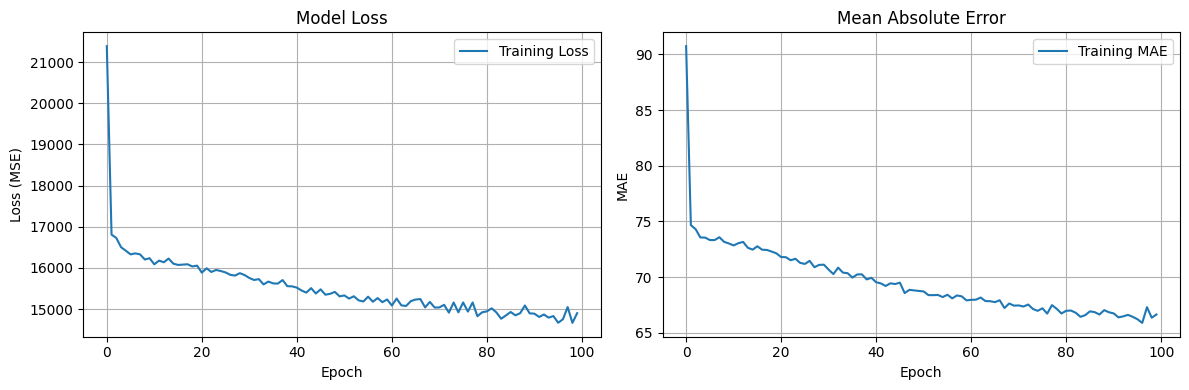

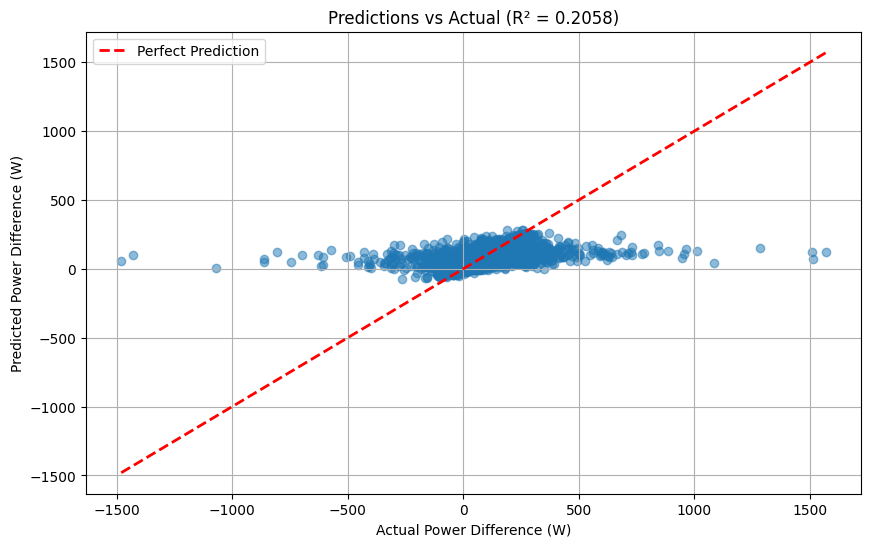

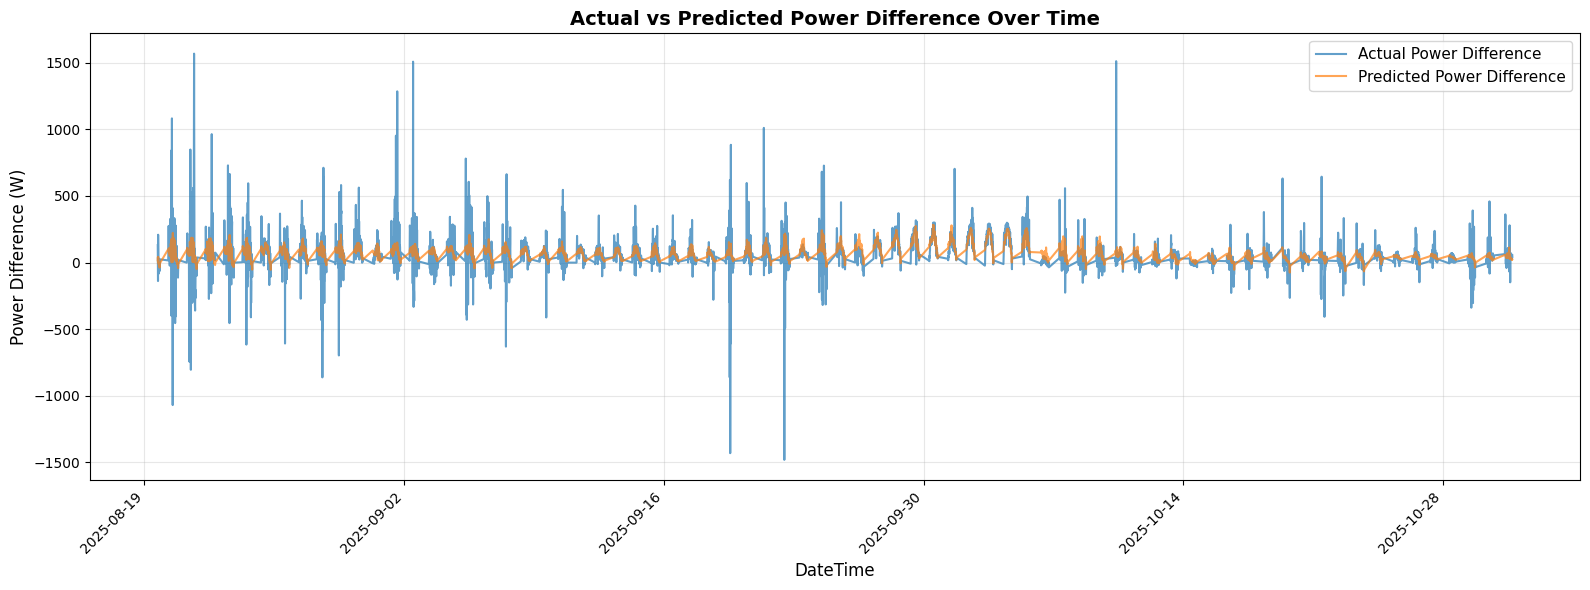

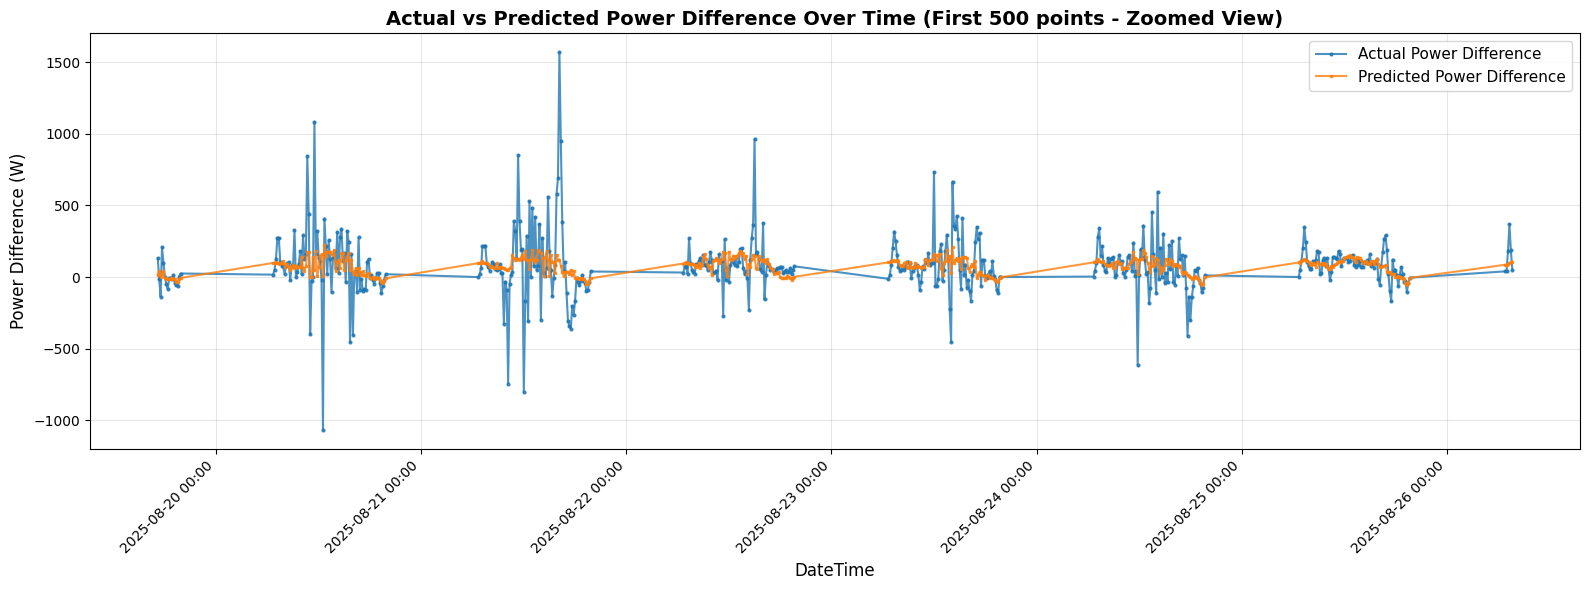

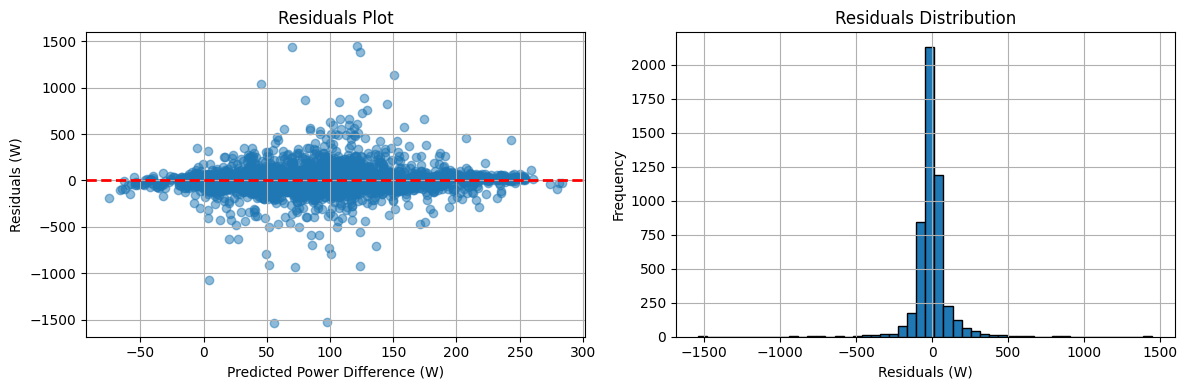


Model training completed!
Scaler and model are ready for predictions.


In [78]:
# Filter out rows where either sensor's power is 0
merged_filtered = merged[(merged['power_W_17'] != 0) & (merged['power_W_20'] != 0)].copy()

print(f"Original merged data shape: {merged.shape}")
print(f"Filtered data shape (after removing rows with power = 0): {merged_filtered.shape}")
print(f"Rows removed: {len(merged) - len(merged_filtered)}")

# Compute differences (sensor_20 - sensor_17) for each factor
differences = pd.DataFrame()
differences['datetime'] = merged_filtered['datetime']

# Calculate differences
differences['temp_diff_C'] = merged_filtered['upper_temp_C_20'] - merged_filtered['upper_temp_C_17']
differences['humidity_diff_pct'] = merged_filtered['upper_humidity_20'] - merged_filtered['upper_humidity_17']
differences['irradiance_diff'] = merged_filtered['upper_irradiance_20'] - merged_filtered['upper_irradiance_17']
differences['power_diff_W'] = merged_filtered['power_W_20'] - merged_filtered['power_W_17']

# Extract temporal features with cyclical encoding
# Cyclical encoding helps the model understand that hour 23 and hour 0 are close,
# and day 365 and day 1 are close in the yearly cycle
differences['hour_of_day'] = differences['datetime'].dt.hour
differences['day_of_year'] = differences['datetime'].dt.dayofyear

# Cyclical encoding: sine and cosine transformations
differences['hour_sin'] = np.sin(2 * np.pi * differences['hour_of_day'] / 24)
differences['hour_cos'] = np.cos(2 * np.pi * differences['hour_of_day'] / 24)
differences['day_sin'] = np.sin(2 * np.pi * differences['day_of_year'] / 365)
differences['day_cos'] = np.cos(2 * np.pi * differences['day_of_year'] / 365)

# Sort by datetime
differences = differences.sort_values('datetime').reset_index(drop=True)

print("Differences (Sensor 20 - Sensor 17):")
print(f"Data shape: {differences.shape}")
print(f"\nFirst few rows:")
print(differences.head(20))
print(f"\nLast few rows:")
print(differences.tail(20))

# Save differences to a new Excel file
output_file = 'data/sensor_17_20_differences.xlsx'
differences.to_excel(output_file, index=False)
print(f"\nDifferences data saved to: {output_file}")

# Neural Network Model Training (after filtering out zeros)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Prepare features and target
# Using cyclical encoding for temporal features instead of raw values
feature_cols = ['irradiance_diff', 'temp_diff_C', 'humidity_diff_pct', 
                'hour_sin', 'hour_cos', 'day_sin', 'day_cos']
target_col = 'power_diff_W'

X = differences[feature_cols].values
y = differences[target_col].values

print(f"\n{'='*60}")
print(f"Neural Network Training")
print(f"{'='*60}")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature statistics before normalization:")
print(differences[feature_cols].describe())

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nFeature statistics after normalization:")
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)
print(X_scaled_df.describe())

# Build neural network model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_scaled.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae', 'mse']
)

# Display model architecture
print("\nModel Architecture:")
model.summary()

# Train the model (using all data, no validation split as requested)
print("\nTraining model...")
history = model.fit(
    X_scaled, y,
    epochs=100,
    batch_size=32,
    verbose=1
)

# Make predictions
y_pred = model.predict(X_scaled, verbose=0).flatten()

# Calculate metrics
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"\n{'='*60}")
print(f"Model Performance (on all training data)")
print(f"{'='*60}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {np.sqrt(mse):.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot predictions vs actual (scatter plot)
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Power Difference (W)')
plt.ylabel('Predicted Power Difference (W)')
plt.title(f'Predictions vs Actual (R² = {r2:.4f})')
plt.legend()
plt.grid(True)
plt.show()

# Plot actual vs predicted over time (time series)
plt.figure(figsize=(16, 6))
datetime_values = differences['datetime'].values
plt.plot(datetime_values, y, label='Actual Power Difference', alpha=0.7, linewidth=1.5)
plt.plot(datetime_values, y_pred, label='Predicted Power Difference', alpha=0.7, linewidth=1.5)
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Power Difference (W)', fontsize=12)
plt.title('Actual vs Predicted Power Difference Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Format x-axis dates
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot actual vs predicted over time (zoomed view for better detail)
# Show first 500 points for clarity
n_points = min(500, len(datetime_values))
plt.figure(figsize=(16, 6))
plt.plot(datetime_values[:n_points], y[:n_points], label='Actual Power Difference', 
         alpha=0.8, linewidth=1.5, marker='o', markersize=2)
plt.plot(datetime_values[:n_points], y_pred[:n_points], label='Predicted Power Difference', 
         alpha=0.8, linewidth=1.5, marker='s', markersize=2)
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Power Difference (W)', fontsize=12)
plt.title(f'Actual vs Predicted Power Difference Over Time (First {n_points} points - Zoomed View)', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Format x-axis dates
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot residuals
residuals = y - y_pred
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Power Difference (W)')
plt.ylabel('Residuals (W)')
plt.title('Residuals Plot')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=50, edgecolor='black')
plt.xlabel('Residuals (W)')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nModel training completed!")
print(f"Scaler and model are ready for predictions.")
